## Imports

In [1]:
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300



Result = namedtuple('Result', ['partisans', "sims"])
Sim = namedtuple("Sim", ["asymptotic", "non_partisans_mean"])

In [2]:
PARTISAN_BIAS = 0.3
TRUE_BIAS = 0.6

## Load data

In [7]:
import json
results_by_partisan = defaultdict(list[Sim])

with open("../output/bigexperiment-1.log", 'r') as f:
    for line in f:
        d = json.loads(line)

        results_by_partisan[d['partisans']].append(
            Sim(d['asymptotic'], d['non_partisans_mean']))

results = [Result(k, v) for k, v in results_by_partisan.items()]
results.sort(key=lambda x: x.partisans)


## Dwell bias

In [8]:
def find_min_max(x):
    return min(x), max(x)

In [9]:
from enum import Enum

DwellBias = Enum("DwellBias", "TRUE PARTISAN OTHER NON_CONVERGED")

EPSILON = 0.025  # if true bias is 0.60, consider equal if in the range 0.575 to 0.625. 
START_INDEX = 2000

def find_dwell_bias(non_partisan_mean: float) -> DwellBias:
    # all non partisans have the partisan bias
    if np.isclose(non_partisan_mean, PARTISAN_BIAS, atol=EPSILON):
        return DwellBias.PARTISAN

    # all non-partisans have the true bias
    elif np.isclose(non_partisan_mean, TRUE_BIAS, atol=EPSILON):
        return DwellBias.TRUE

    else: 
        return DwellBias.OTHER

assert find_dwell_bias(0.305) == DwellBias.PARTISAN
assert find_dwell_bias(0) == DwellBias.OTHER
assert find_dwell_bias(0.575) == DwellBias.TRUE

In [10]:
DwellBiasPeakResult = namedtuple("DwellBiasPeakResult", "time peak non_partisan_mean")

def find_dwell_bias_peaks(result: Sim, start_index: int=0) -> dict[DwellBias, list[DwellBiasPeakResult]]:
    asymptotic = result.asymptotic[start_index:]
    non_partisans_mean = result.non_partisans_mean[start_index:]

    # find the indices of each element of asymptotic that is greater than the next element
    # (i.e. the indices of the peaks)
    asymptotic_peak_idxs = np.where(np.diff(asymptotic) < 0)[0]
    for i in asymptotic_peak_idxs: # make sure that code above worked correctly
        assert (asymptotic[i] > 0 and asymptotic[i+1] == 0)
    
    if asymptotic[-1] > 0:
        asymptotic_peak_idxs = np.append(asymptotic_peak_idxs, len(asymptotic) - 1)

    asymptotic_peaks = [asymptotic[i] for i in asymptotic_peak_idxs]

    dwell_biases = [find_dwell_bias(non_partisans_mean[i]) for i in asymptotic_peak_idxs]

    # list of each bias and the asymptotic learning peaks that correspond to it
    dwell_bias_peaks_by_bias = {bias: [] for bias in DwellBias}

    dwell_bias_peaks = zip(asymptotic_peak_idxs, dwell_biases, asymptotic_peaks)
    for i, bias, peak in dwell_bias_peaks:
        time = i + start_index
        dwell_bias_peaks_by_bias[bias].append(DwellBiasPeakResult(time, peak, non_partisans_mean[i]))
    
    return dict(dwell_bias_peaks_by_bias)

def find_start_of_stability(result: Sim) -> int | None:
    if result.asymptotic[-1] > 0:
        return len(result.asymptotic) - result.asymptotic[-1]
    else:
        return None

### Checking nothing didn't converge

In [11]:
for result in results:
    for sim in result.sims:
        dwell_bias_peaks_by_bias = find_dwell_bias_peaks(sim, start_index=START_INDEX)
        assert dwell_bias_peaks_by_bias[DwellBias.NON_CONVERGED] == []

In [12]:
dwell_bias_peaks_by_bias[DwellBias.PARTISAN]

[DwellBiasPeakResult(time=9999, peak=9985, non_partisan_mean=0.3000000498663999)]

Text(0.5, 0, 'fraction of partisans')

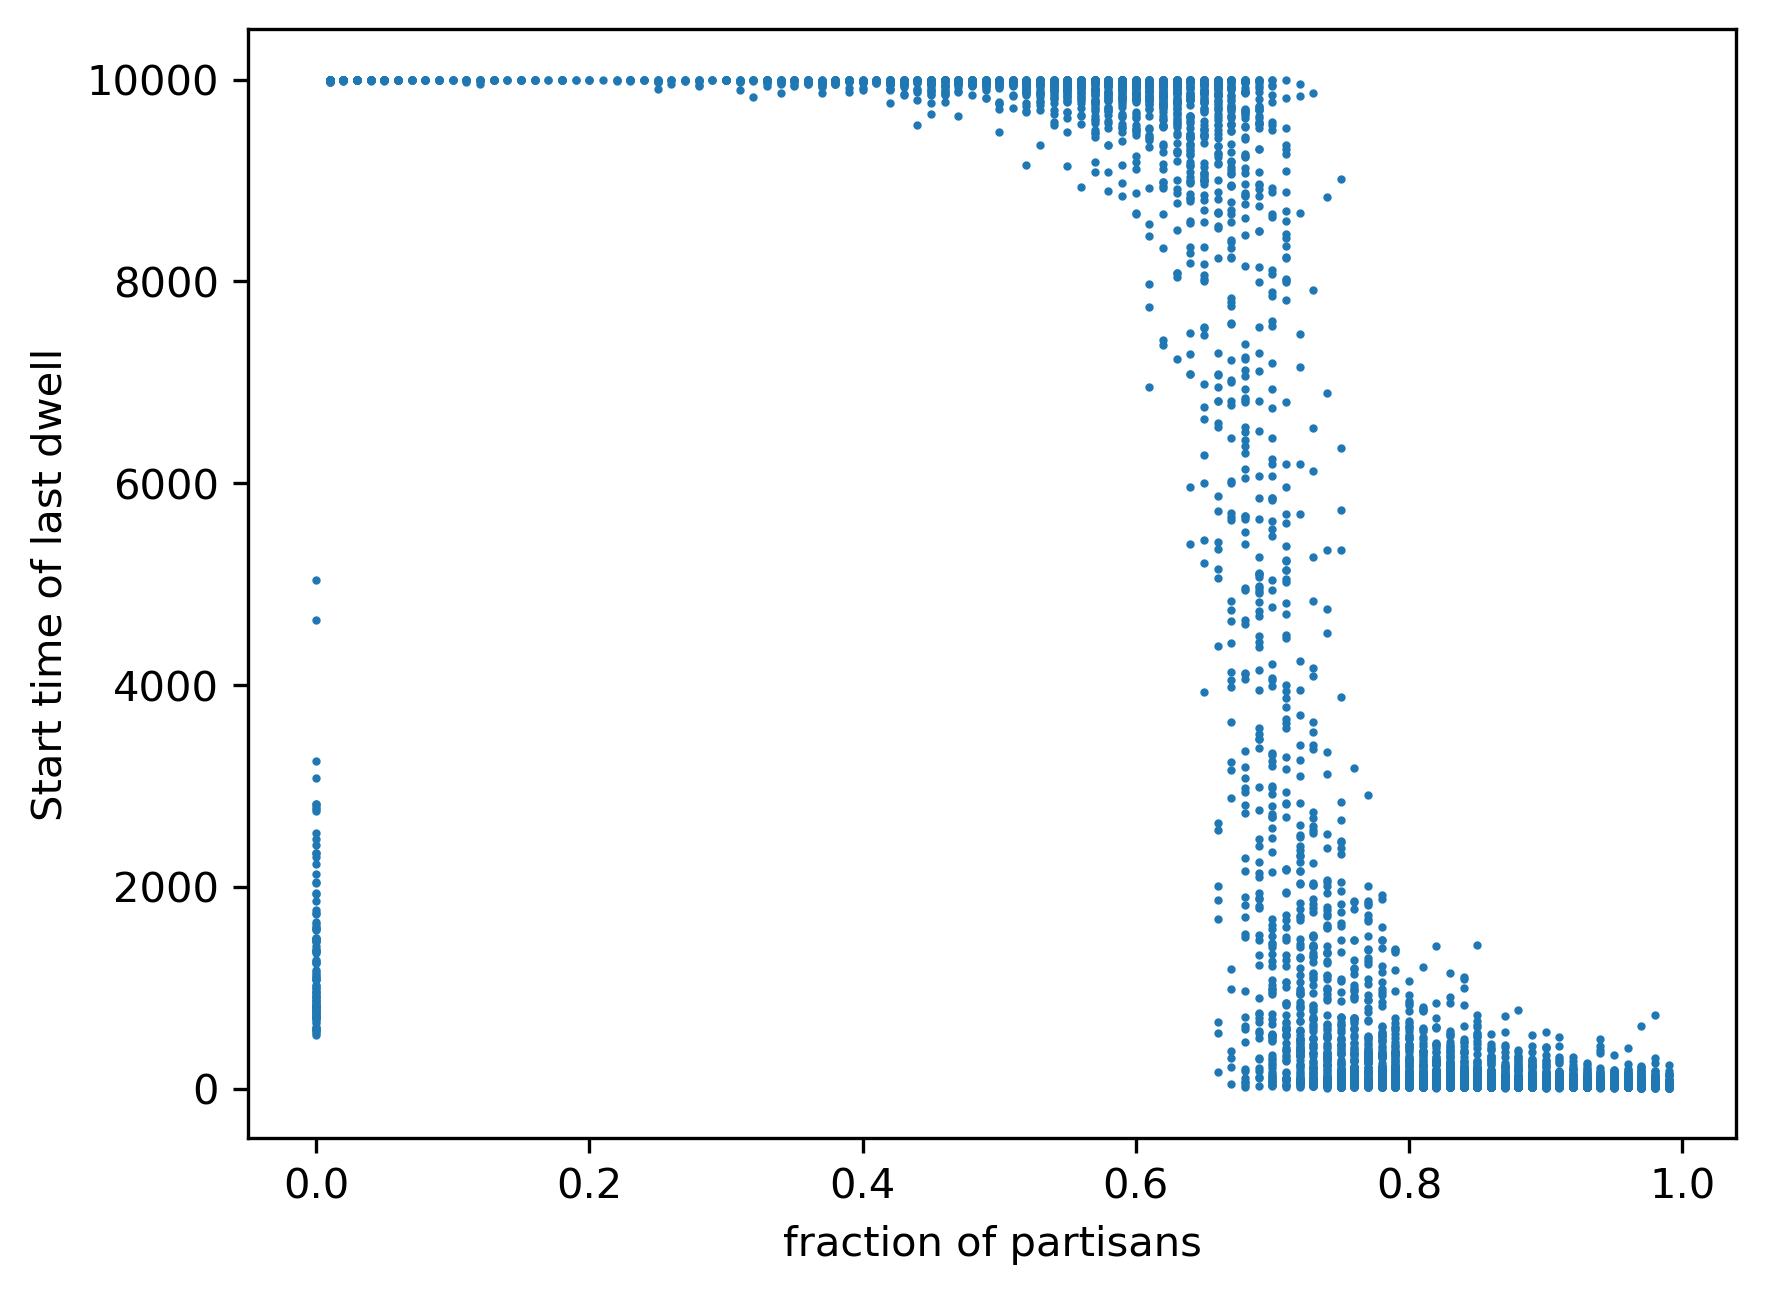

In [13]:
bops = []
for result in results:
    for sim in result.sims:
        y = find_start_of_stability(sim)
        if y is not None:
            bops.append((result.partisans,y))

plt.scatter(*zip(*bops), s=1)
plt.ylabel("Start time of last dwell")
plt.xlabel("fraction of partisans")
# plt.xlim(0,2000)


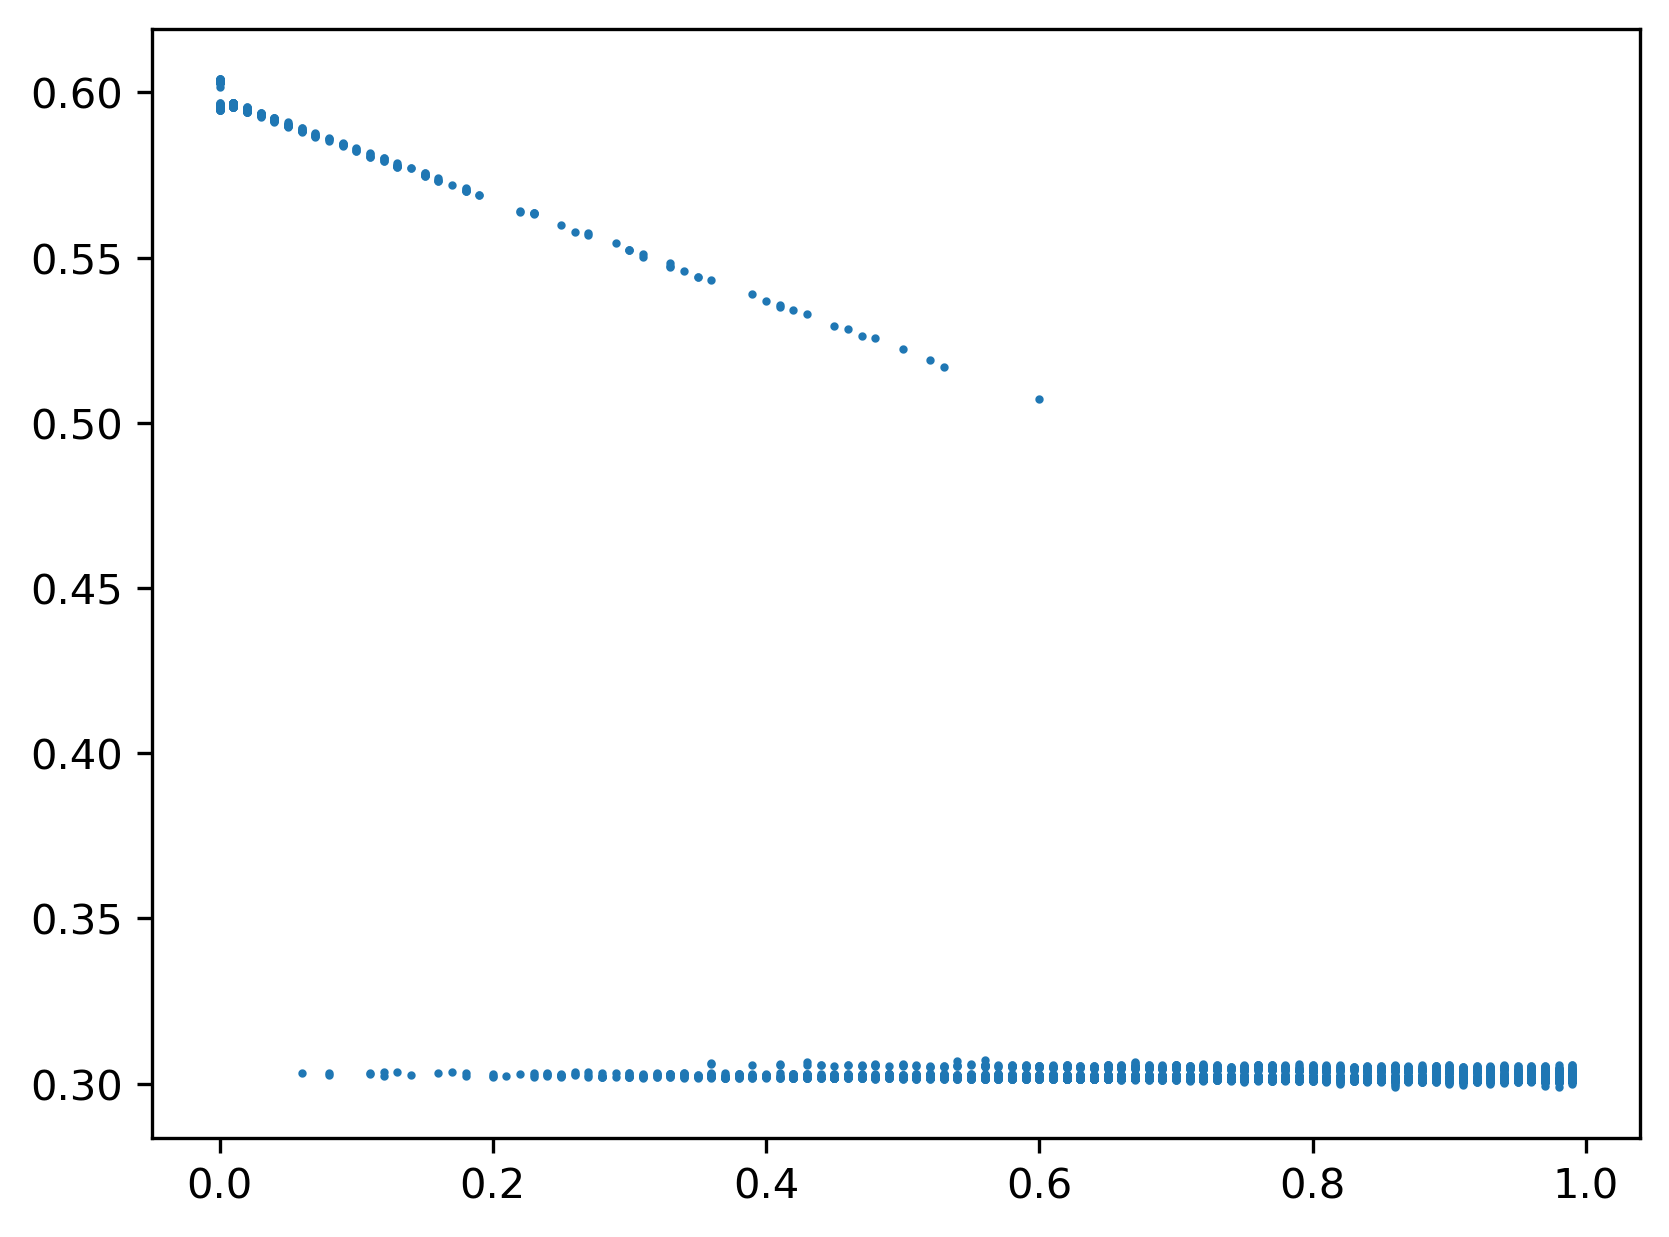

In [14]:
end_belief = []
for result in results:
    for sim in result.sims:
        y = find_start_of_stability(sim)
        if y is not None:
            end_belief.append((result.partisans, sim.non_partisans_mean[y]))
            
plt.scatter(*zip(*end_belief), s=1)

In [15]:
# rename the columns 
last_time_df = pd.DataFrame(bops, columns=["frac_partisans", "last_start_time"])

<AxesSubplot:xlabel='frac_partisans', ylabel='last_start_time'>

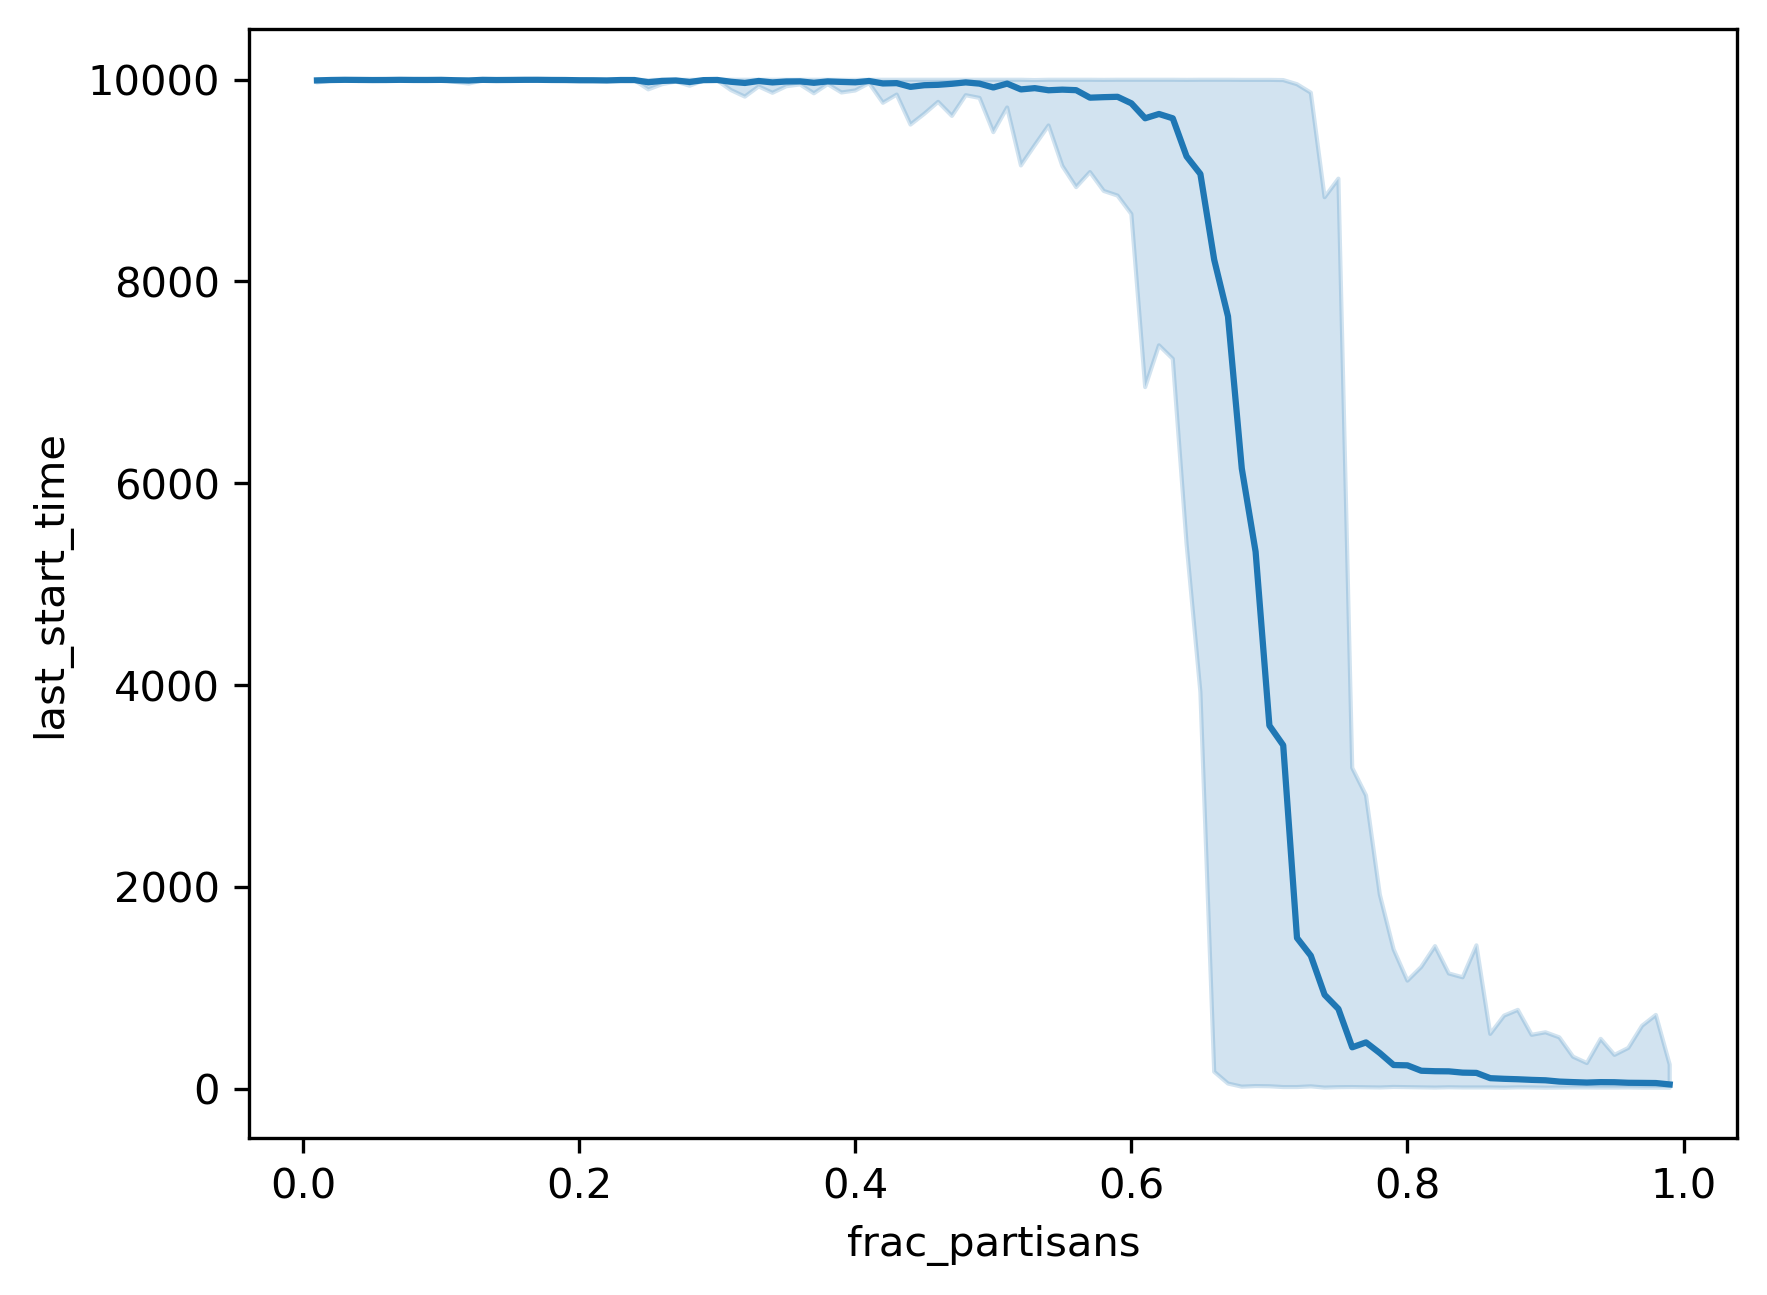

In [16]:
#sns.scatterplot(data=df, x=0, y=1, s=1)
sns.lineplot(data=last_time_df[last_time_df["frac_partisans"] >= 0.01] , x="frac_partisans", y="last_start_time", errorbar= find_min_max)

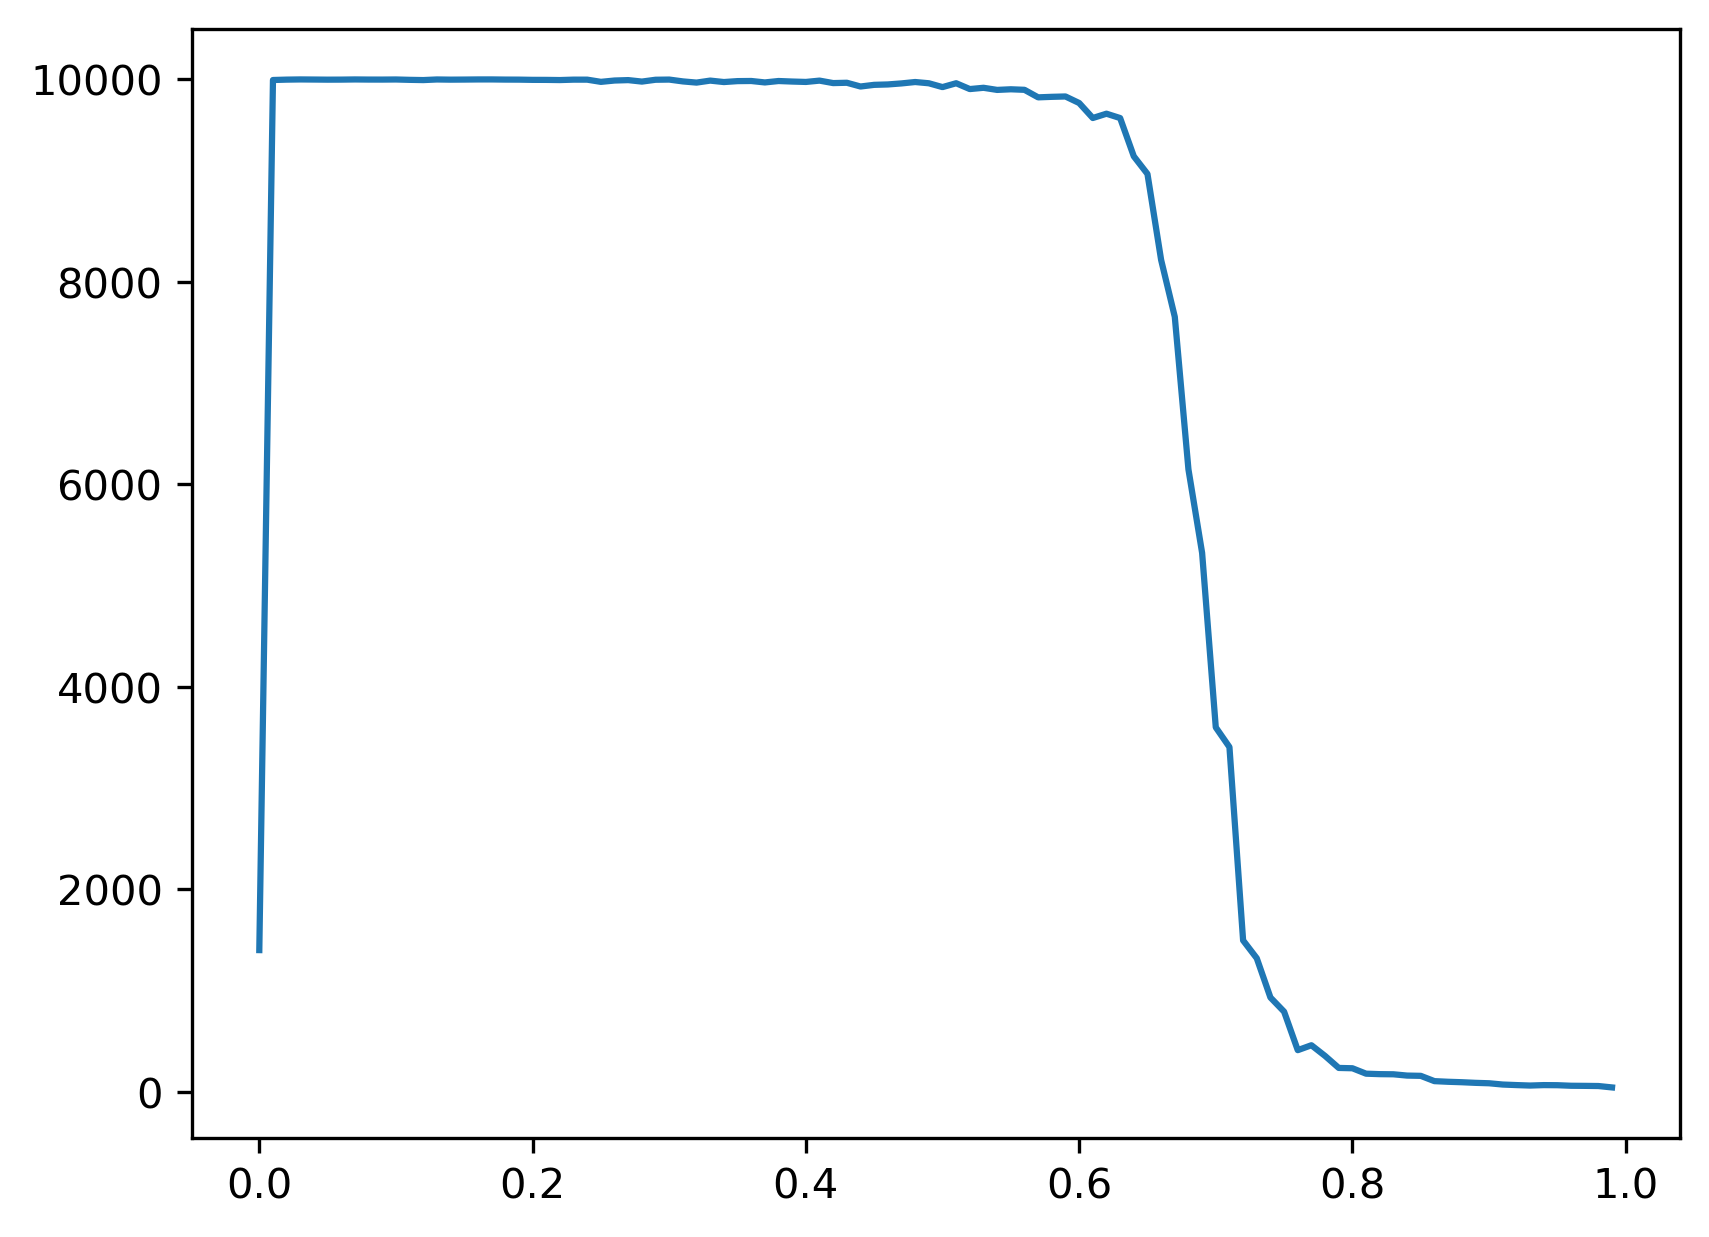

In [17]:
means = []
mean = []
for result in results:
    for sim in result.sims:
        y = find_start_of_stability(sim)
        if y is not None:
            mean.append(y)
    means.append(np.mean(mean))
    mean = []

plt.plot([r.partisans for r in results], means)



In [18]:
[result.peak for result in dwell_bias_peaks_by_bias[DwellBias.PARTISAN]]

[9985]

In [19]:
def mean_dwell_time(sim: Sim, dwell_bias: DwellBias):
    """ find the mean dwell time of a certain dwell bias """
    return np.mean([db.peak for db in find_dwell_bias_peaks(sim)[dwell_bias]])


In [20]:
def plot_mean(dwell_bias: DwellBias): 
    fracs = [result.partisans for result in results]
    mean_dt_true = np.array([np.mean([mean_dwell_time(sim, dwell_bias) for sim in result.sims]) for result in results])
    np.nan_to_num(mean_dt_true, copy=False)

    plt.plot(fracs, mean_dt_true, label=dwell_bias.name)


In [21]:

rows = []
for result in results:
    for sim in result.sims:
        peaks = find_dwell_bias_peaks(sim)
        for bias, peak_results in peaks.items():
            for peak_result in peak_results:
                rows.append({
                    "partisans": result.partisans,
                    "bias": bias.name,
                    "dwell_time_idx": peak_result.time,
                    "dwell_time": peak_result.peak,
                    "non_partisan_mean": peak_result.non_partisan_mean
                })
df = pd.DataFrame(rows)


In [22]:
df

,partisans,bias,dwell_time_idx,dwell_time,non_partisan_mean
0,0.00,TRUE,925,9,0.604221
1,0.00,TRUE,933,7,0.606218
2,0.00,TRUE,946,1,0.606073
3,0.00,TRUE,949,1,0.606217
4,0.00,TRUE,962,1,0.606071
...,...,...,...,...,...
1425694,0.99,PARTISAN,9999,9983,0.300000
1425695,0.99,PARTISAN,17,5,0.306934
1425696,0.99,PARTISAN,42,1,0.305737
1425697,0.99,PARTISAN,9999,9955,0.300000


<AxesSubplot:ylabel='Frequency'>

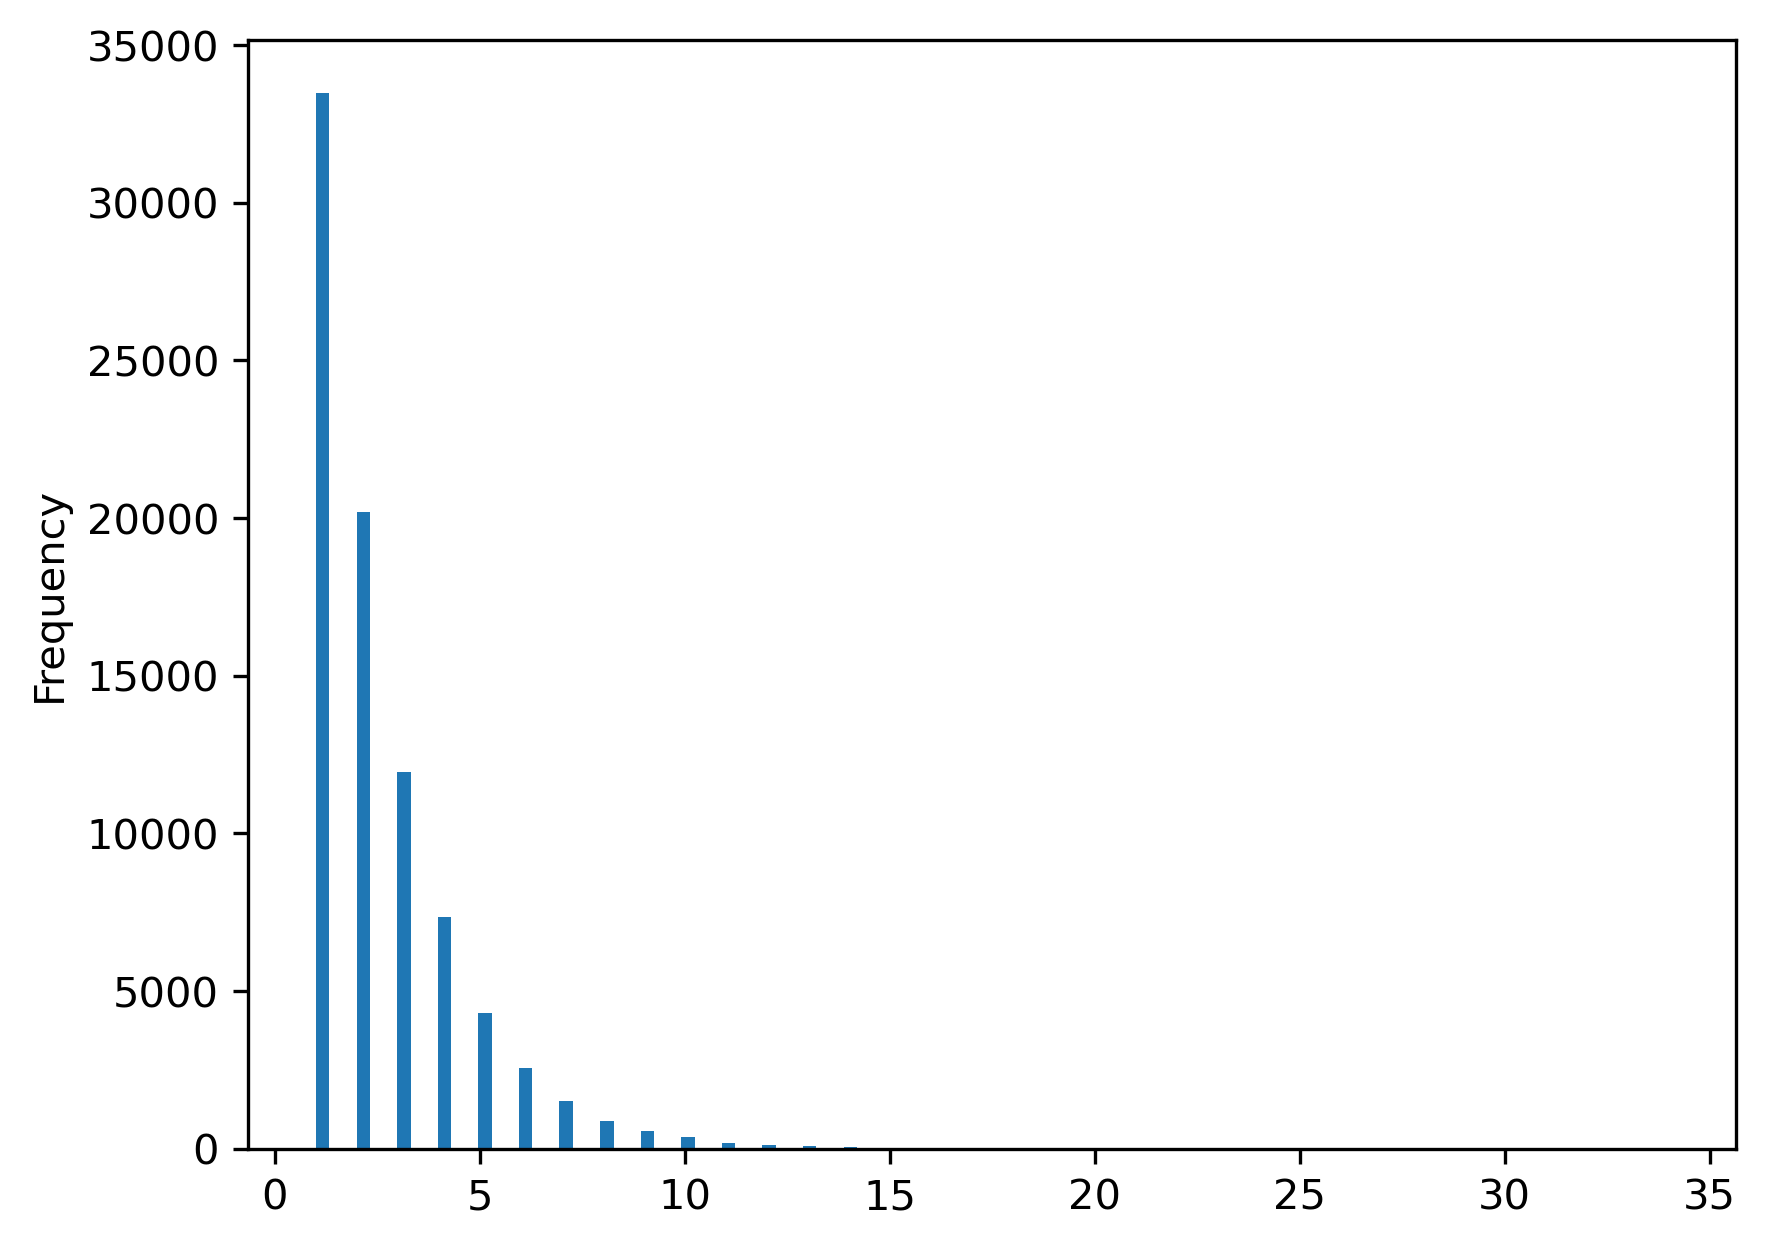

In [23]:
# df[df.partisans == 0.01]
df[(df.partisans == 0.02)].dwell_time.plot.hist(bins=100)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1541b0b80> (for post_execute):


KeyboardInterrupt: 

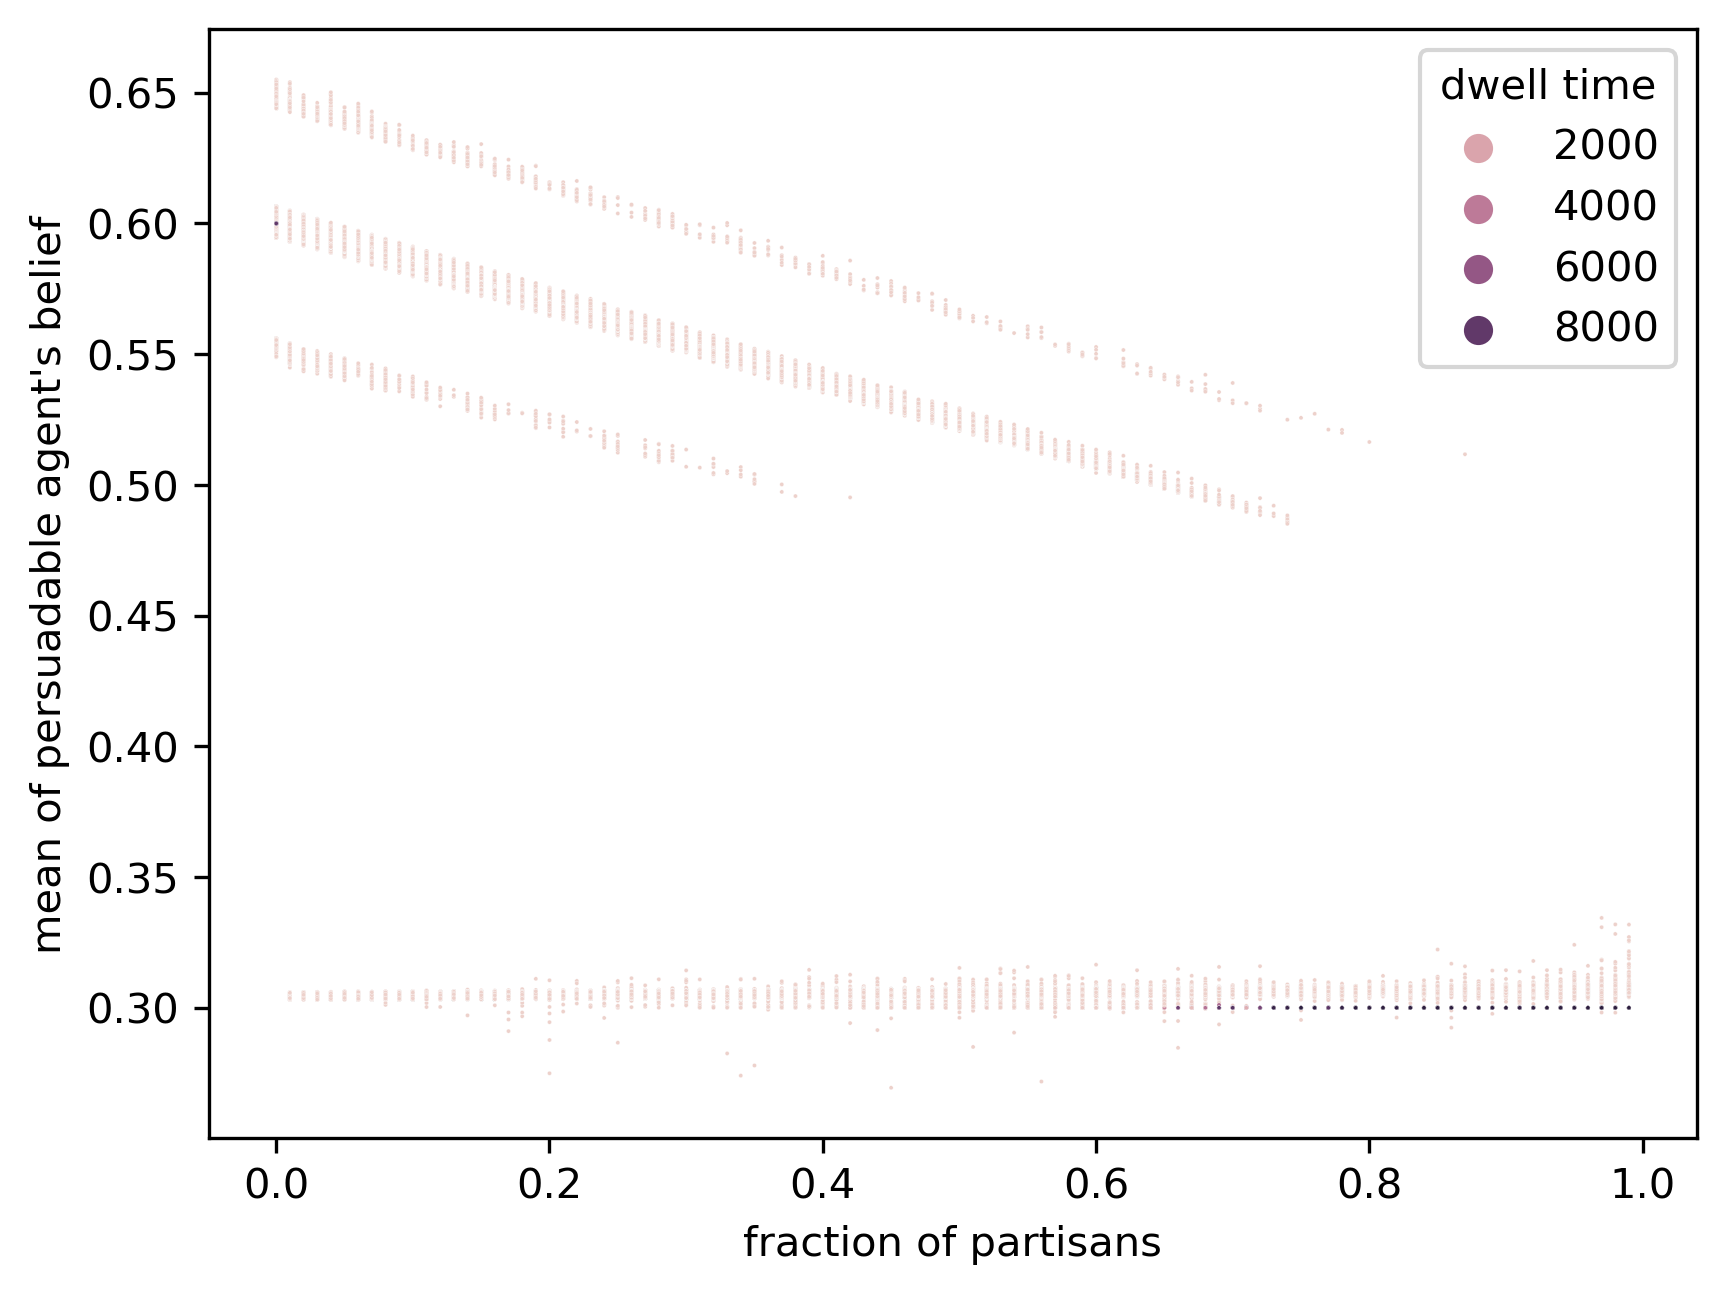

In [24]:
sns.scatterplot(df, x="partisans", y="non_partisan_mean", hue="dwell_time", s=1)
plt.xlabel("fraction of partisans")
plt.ylabel("mean of persuadable agent's belief")
plt.legend(title = "dwell time")

/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


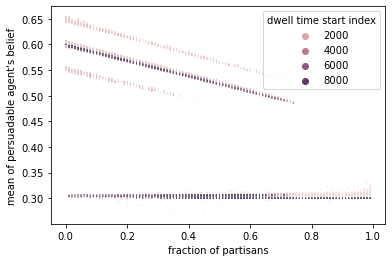

In [ ]:
sns.scatterplot(df, x="partisans", y="non_partisan_mean", hue="dwell_time_idx", s=1)
plt.xlabel("fraction of partisans")
plt.ylabel("mean of persuadable agent's belief")
plt.legend(title = "dwell time start index")

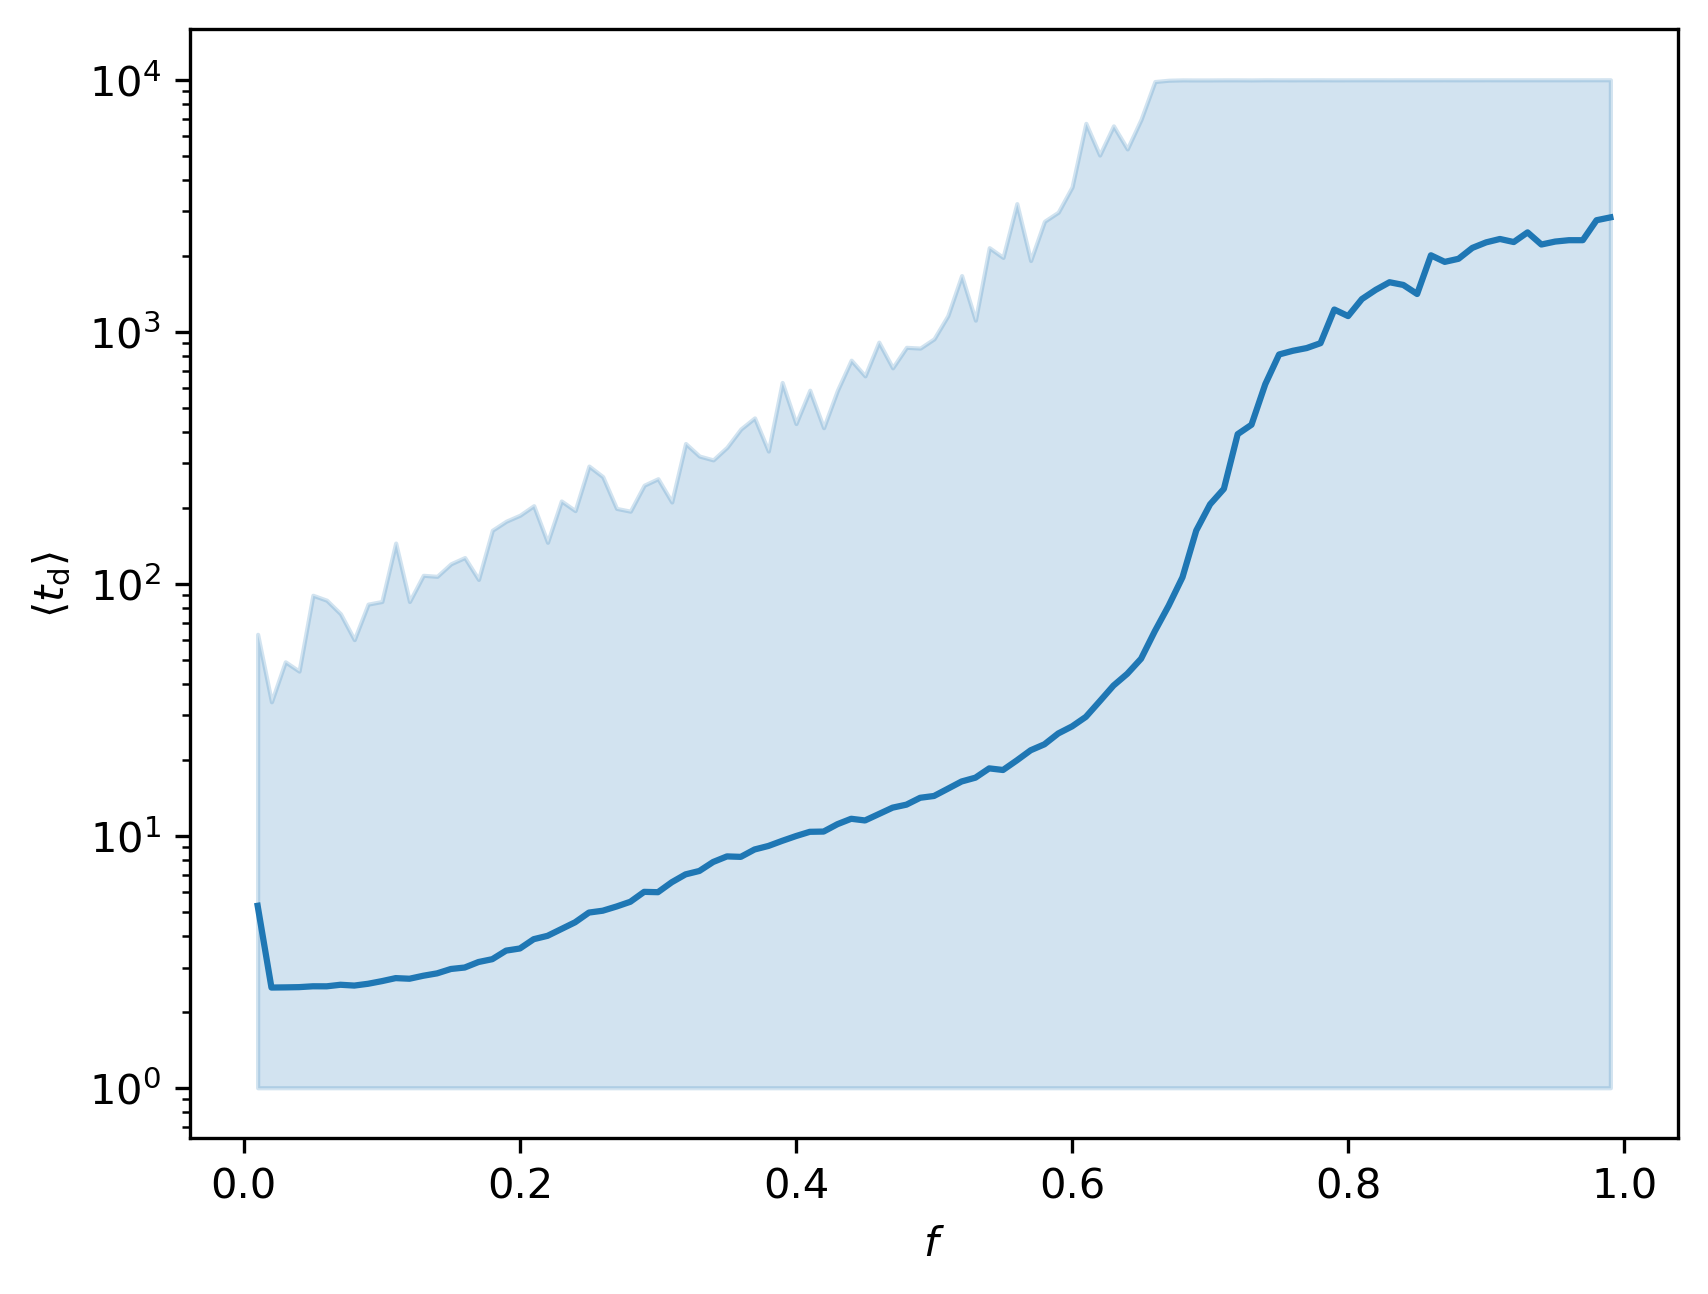

In [28]:
# sns.lineplot(df, x="partisans", y="dwell_time", hue="bias", legend="brief", errorbar= find_min_max)
sns.lineplot(df[df["partisans"] >= 0.01], x="partisans", y="dwell_time", errorbar= find_min_max)
# sns.lineplot(df, x="partisans", y="dwell_time", estimator="median", errorbar= find_min_max)

# plt.xlim(0.7, 0.99)
# plt.ylim(1000, 10000)
plt.xlabel("$f$")
plt.ylabel("$\\langle t_{\\rm d} \\rangle$")
plt.yscale("log")


# 3.2 b

Text(0, 0.5, 'dwell time')

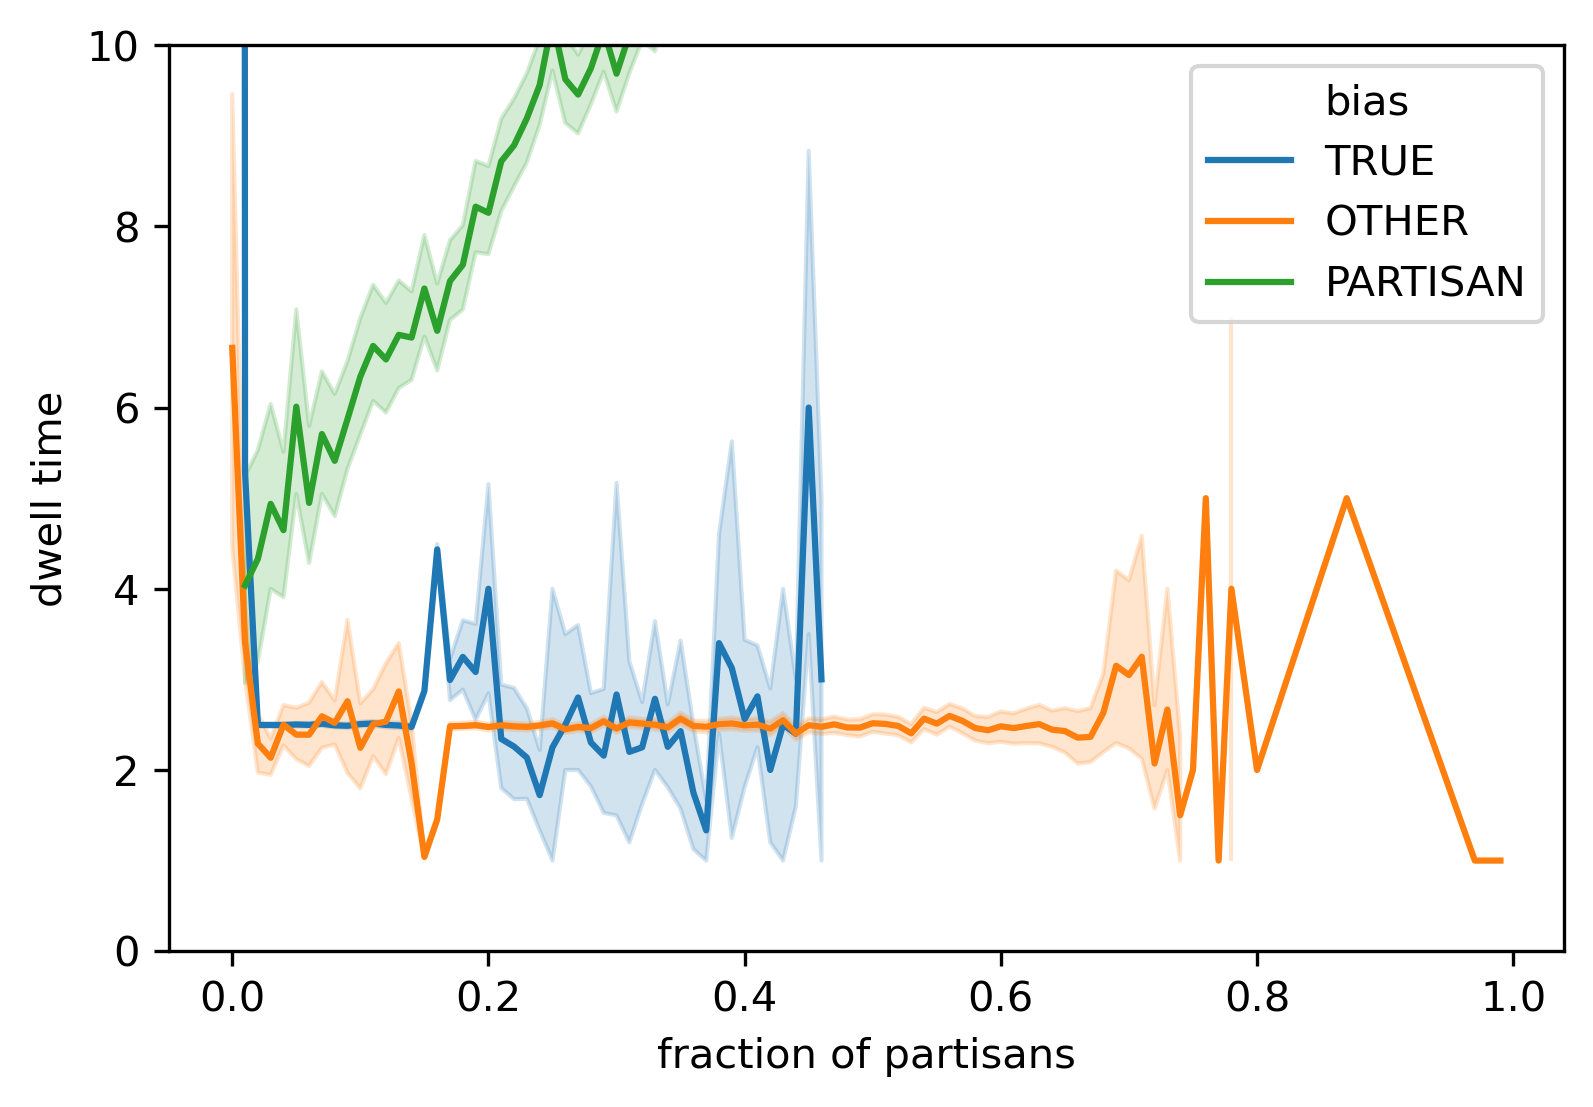

In [292]:
sns.lineplot(df, x="partisans", y="dwell_time", hue="bias", legend="brief")
plt.ylim(0, 10)
# plt.xlim(0.01,1)
plt.xlabel("fraction of partisans")
plt.ylabel("dwell time")

In [23]:
# plot_mean(DwellBias.TRUE)
# plot_mean(DwellBias.PARTISAN)
# plot_mean(DwellBias.OTHER)
# plt.legend()
df[(df.partisans == 0.9) & (df.non_partisan_mean < 0.309) & (df.non_partisan_mean > 0.305)].describe()

,partisans,dwell_time_idx,dwell_time,non_partisan_mean
count,3.220000e+02,322.000000,322.000000,322.000000
mean,9.000000e-01,94.661491,10.527950,0.306931
std,2.223902e-16,89.369897,28.808761,0.000985
min,9.000000e-01,8.000000,1.000000,0.305041
25%,9.000000e-01,28.000000,1.000000,0.306185
50%,9.000000e-01,61.000000,2.000000,0.306806
75%,9.000000e-01,134.000000,6.000000,0.307734
max,9.000000e-01,556.000000,252.000000,0.308955


<AxesSubplot:xlabel='partisans'>

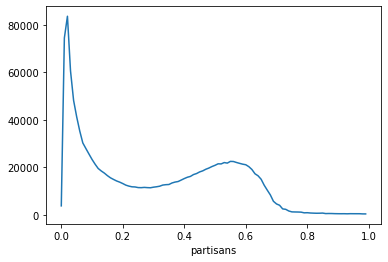

In [154]:
# count the number of partisans 
df.groupby("partisans").count().bias.plot()


In [91]:
df[df.partisans == 0.1].dwell_time.describe()

count    23329.000000
mean         2.648978
std          2.732317
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         85.000000
Name: dwell_time, dtype: float64

In [140]:
df[(df.partisans == 0.1)]

,partisans,bias,dwell_time_idx,dwell_time,non_partisan_mean
431353,0.1,TRUE,994,1,0.585090
431354,0.1,TRUE,1048,1,0.584020
431355,0.1,TRUE,1089,2,0.584342
431356,0.1,TRUE,1145,2,0.583983
431357,0.1,TRUE,1209,2,0.583928
...,...,...,...,...,...
454677,0.1,PARTISAN,2344,14,0.303429
454678,0.1,PARTISAN,5876,2,0.304539
454679,0.1,PARTISAN,6331,5,0.303248
454680,0.1,PARTISAN,8268,2,0.305814


In [93]:
df[df.partisans == 0.9].dwell_time.describe()

count     440.000000
mean     2261.879545
std      4157.156890
min         1.000000
25%         1.000000
50%         4.000000
75%        85.750000
max      9991.000000
Name: dwell_time, dtype: float64

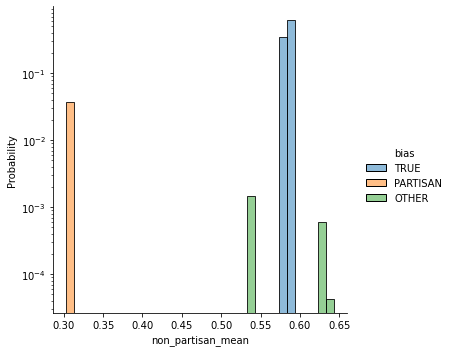

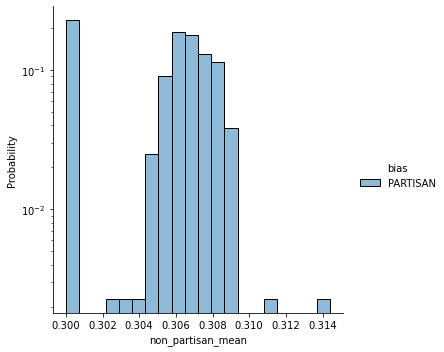

In [254]:
# series = df[df.partisans == 0.9]
# series
sns.displot(df[df.partisans == 0.1], x='non_partisan_mean', hue="bias",stat="probability", binwidth=0.01)
plt.yscale("log")

sns.displot(df[df.partisans == 0.9], x='non_partisan_mean', hue="bias",stat="probability", binwidth=None)
plt.yscale("log")

# Dwell time histogram

In [287]:
from re import T


def plot_dwll_time_and_interval(frac_partisans: float, binwidth: float = 0.01):
    dwell_time_df = df[df.partisans == frac_partisans].groupby("non_partisan_mean").dwell_time.sum().to_frame().reset_index()
    fig, ax = plt.subplots()
    # plot histogram weighted by dwell time
    ax=sns.histplot(dwell_time_df, x='non_partisan_mean', ax=ax, weights="dwell_time",stat="probability", binwidth=binwidth, element="bars", label = "Dwell time steps", fill = True, linewidth=4, edgecolor="white")
    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0],l[0:10])
    
    # Dwell interval histogram
    ax_i = sns.histplot(df[df.partisans == frac_partisans],x='non_partisan_mean',ax=ax, stat="probability", binwidth=binwidth, element="bars", label = "Dwell time interval", fill = False, color= "orange")
    # plt.legend(title=f'$f$ = {frac_partisans}', loc='upper left', labels=['Dwell time steps', 'Dwell time interval'])
    # h,l = ax_i.get_legend_handles_labels()
    # plt.legend(h[0],l[0:10])
    plt.legend(title=f'$f$ = {frac_partisans}', loc='upper center', labels=["",'Dwell time steps', 'Dwell time interval'])
    plt.yscale("log")
    plt.ylabel(" Normalized number ")
    plt.xlim(0.2,0.7)
    plt.xlabel("$\\langle \\theta \\rangle$")



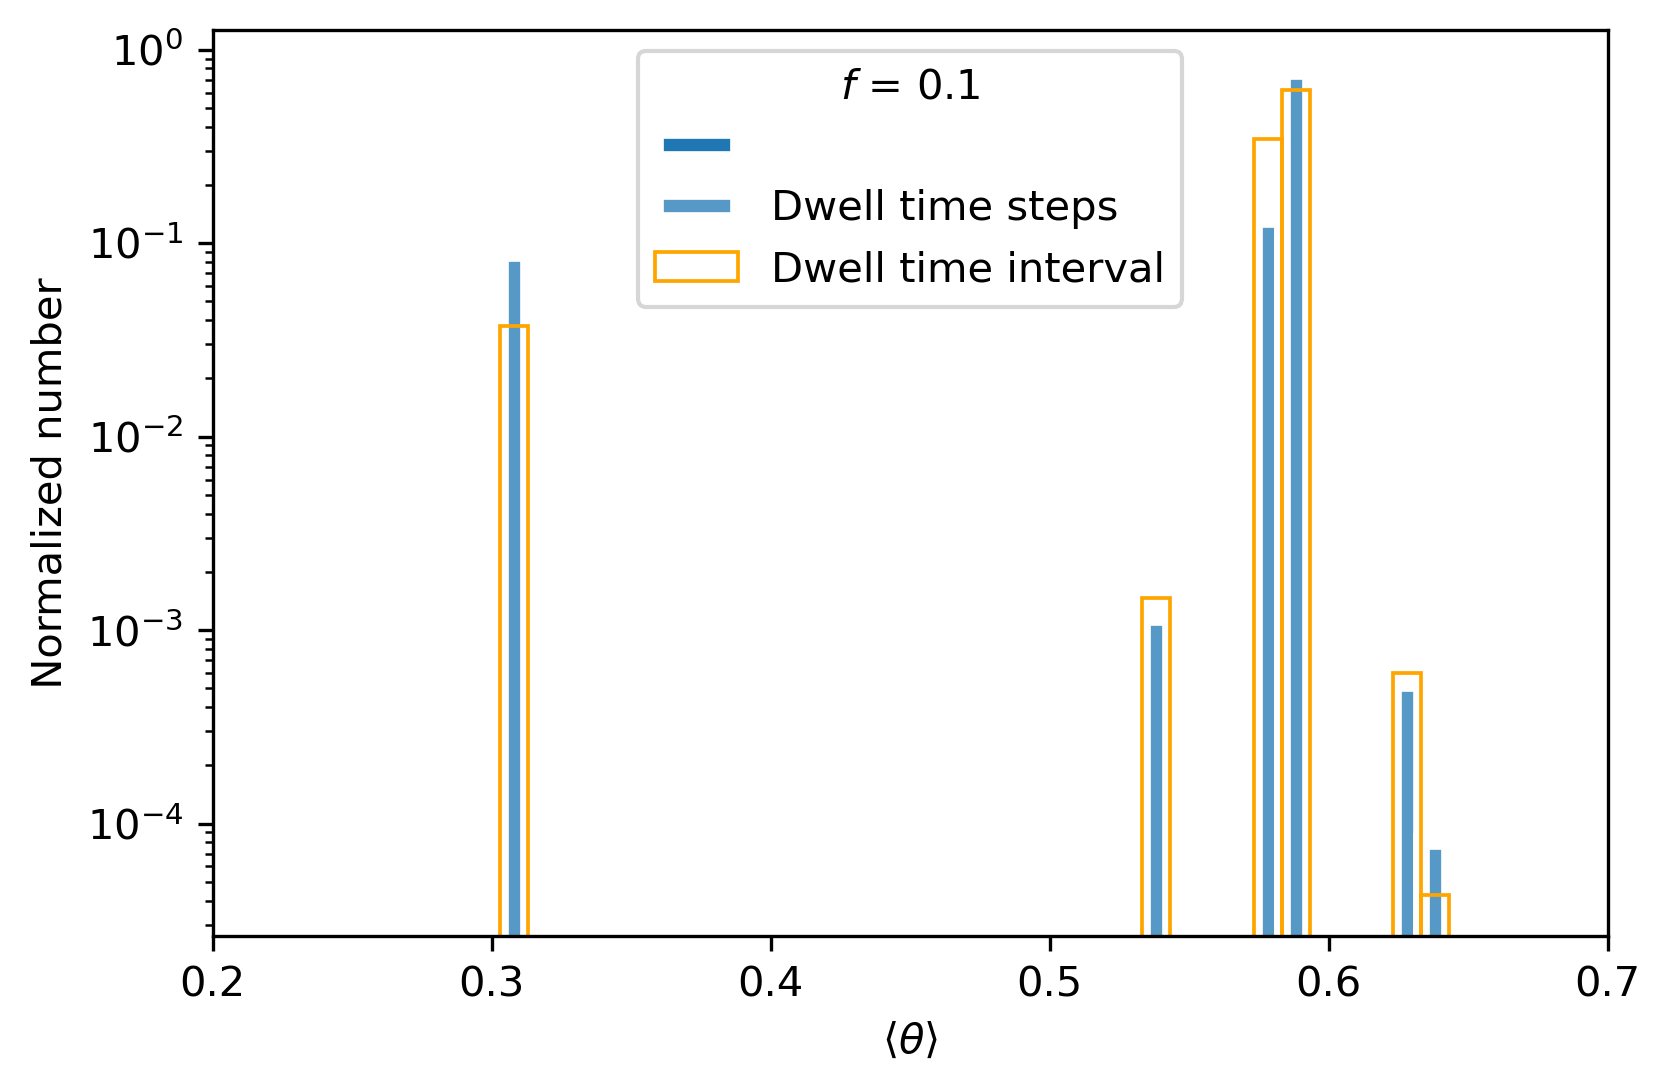

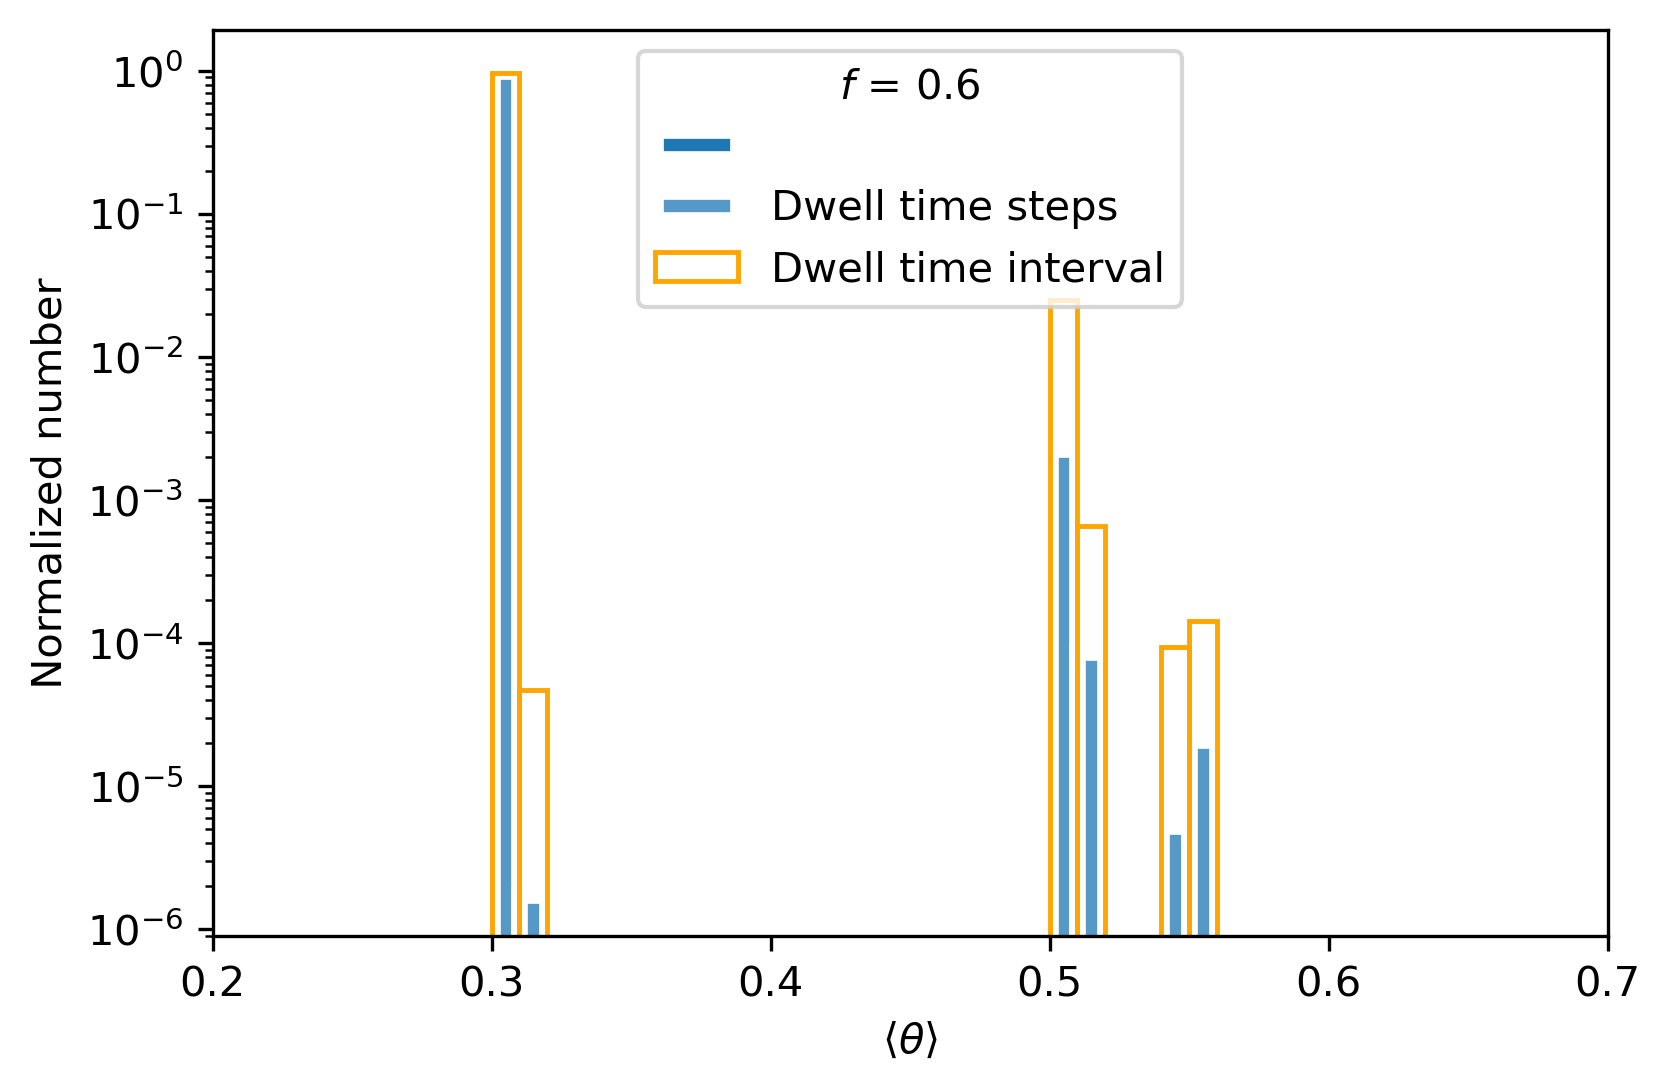

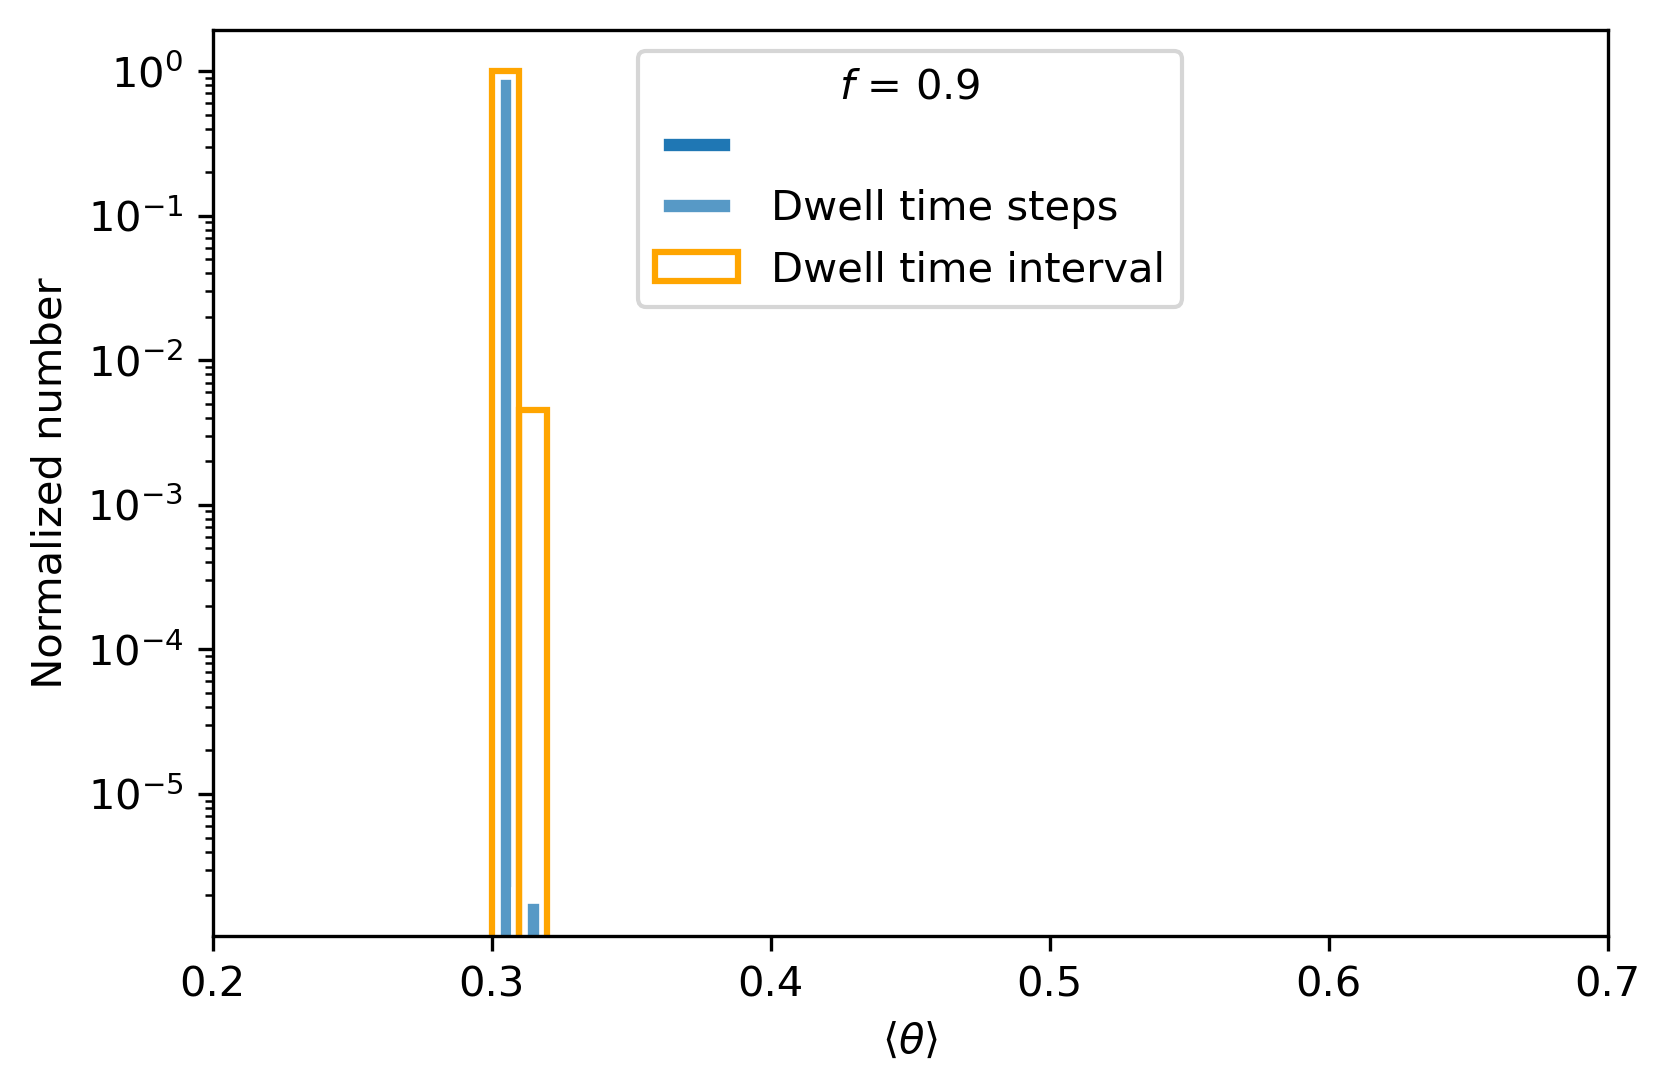

In [288]:
plot_dwll_time_and_interval(0.1)
plot_dwll_time_and_interval(0.6)
plot_dwll_time_and_interval(0.9)

/Users/buyutong/miniforge3/envs/opinion-dynamics/lib/python3.10/site-packages/seaborn/distributions.py:419: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


Text(0.5, 28.33333333333336, "mean of persuadable agent's belief in network with 90% partisans")

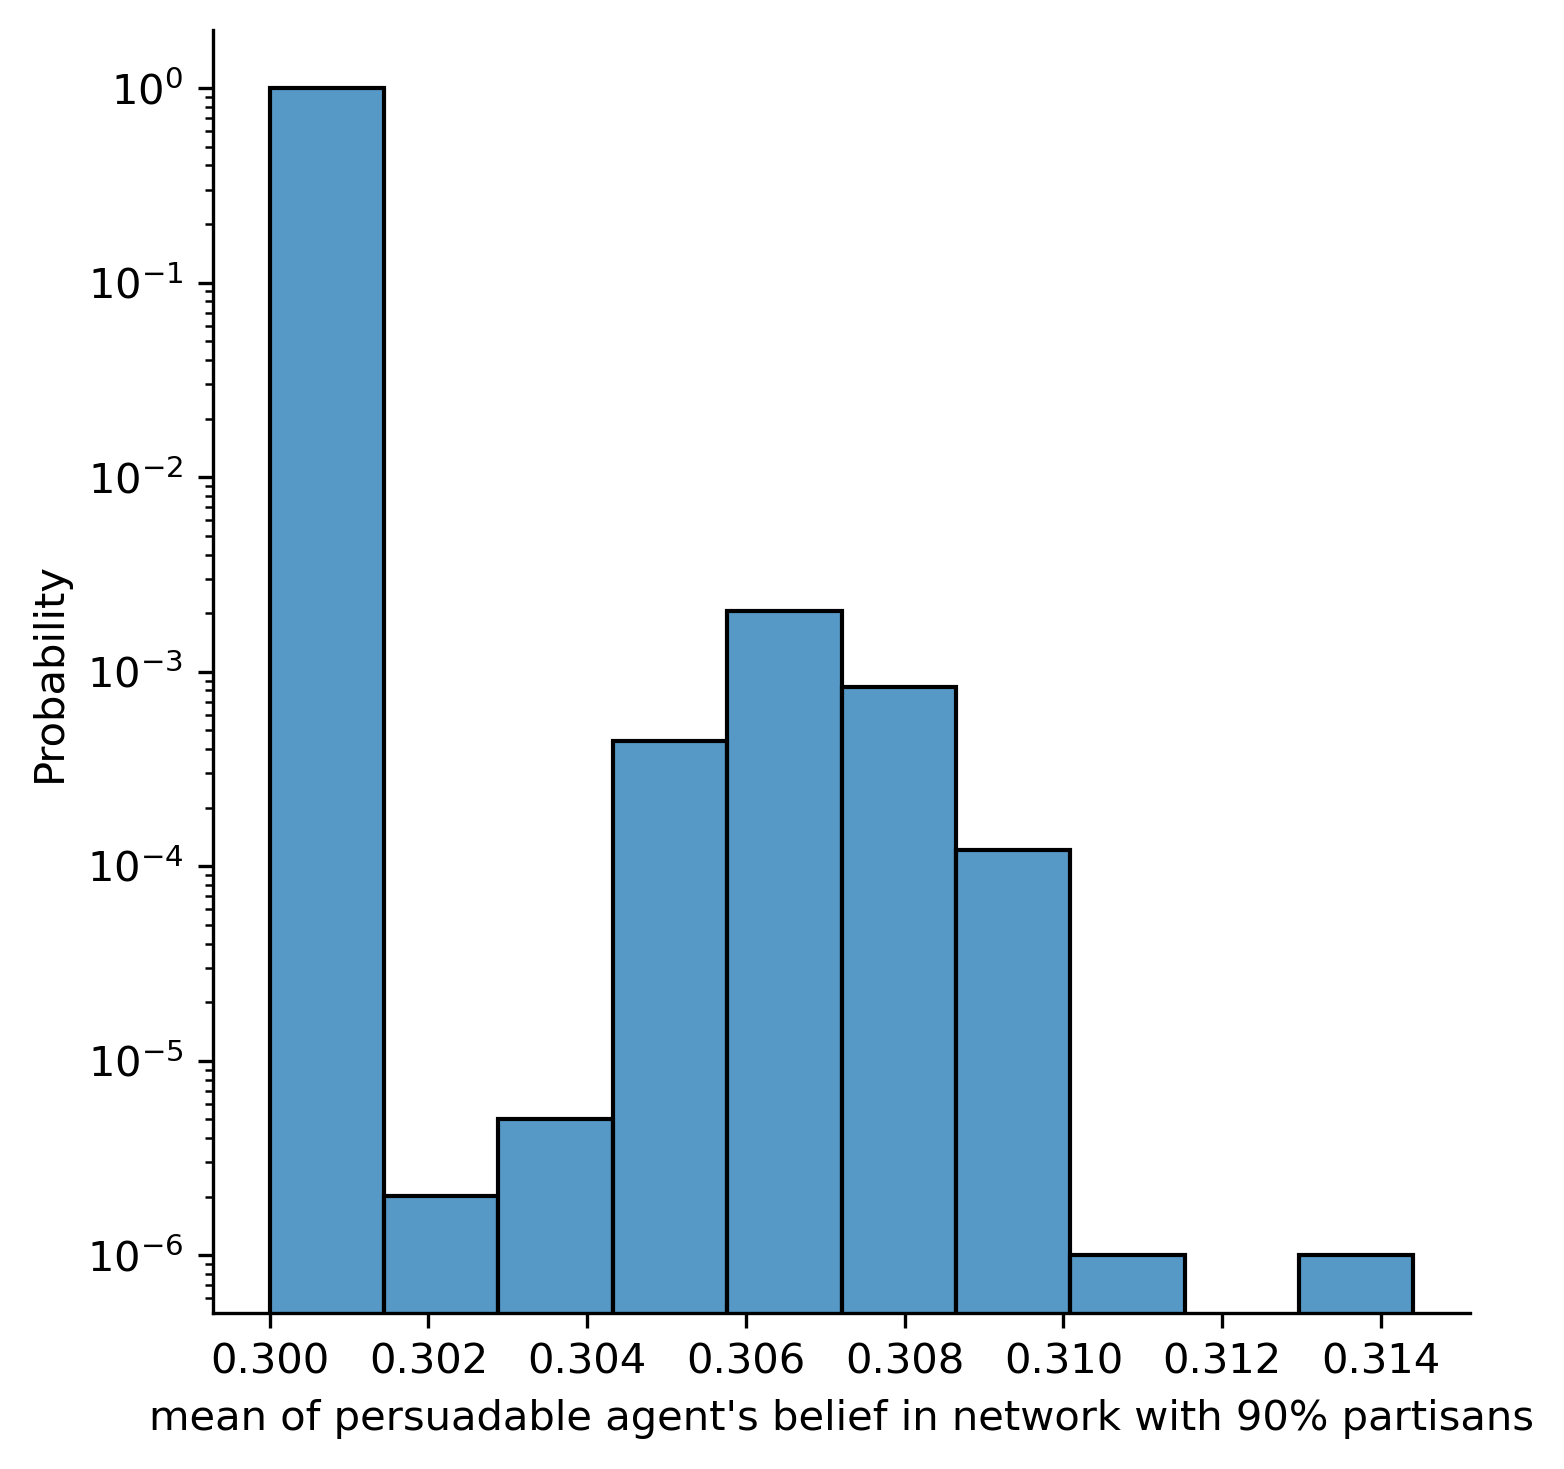

In [285]:
dwell_time_df = df[df.partisans == 0.9].groupby("non_partisan_mean").dwell_time.sum().to_frame().reset_index()
# plot histogram weighted by dwell time
sns.displot(dwell_time_df, x='non_partisan_mean', weights="dwell_time",stat="probability", binwidth=None)
plt.yscale("log")
plt.xlabel("mean of persuadable agent's belief in network with 90% partisans")
# plt.xlim(0,1)

Text(0.5, 28.33333333333336, "mean of persuadable agent's belief in network with 90% partisans")

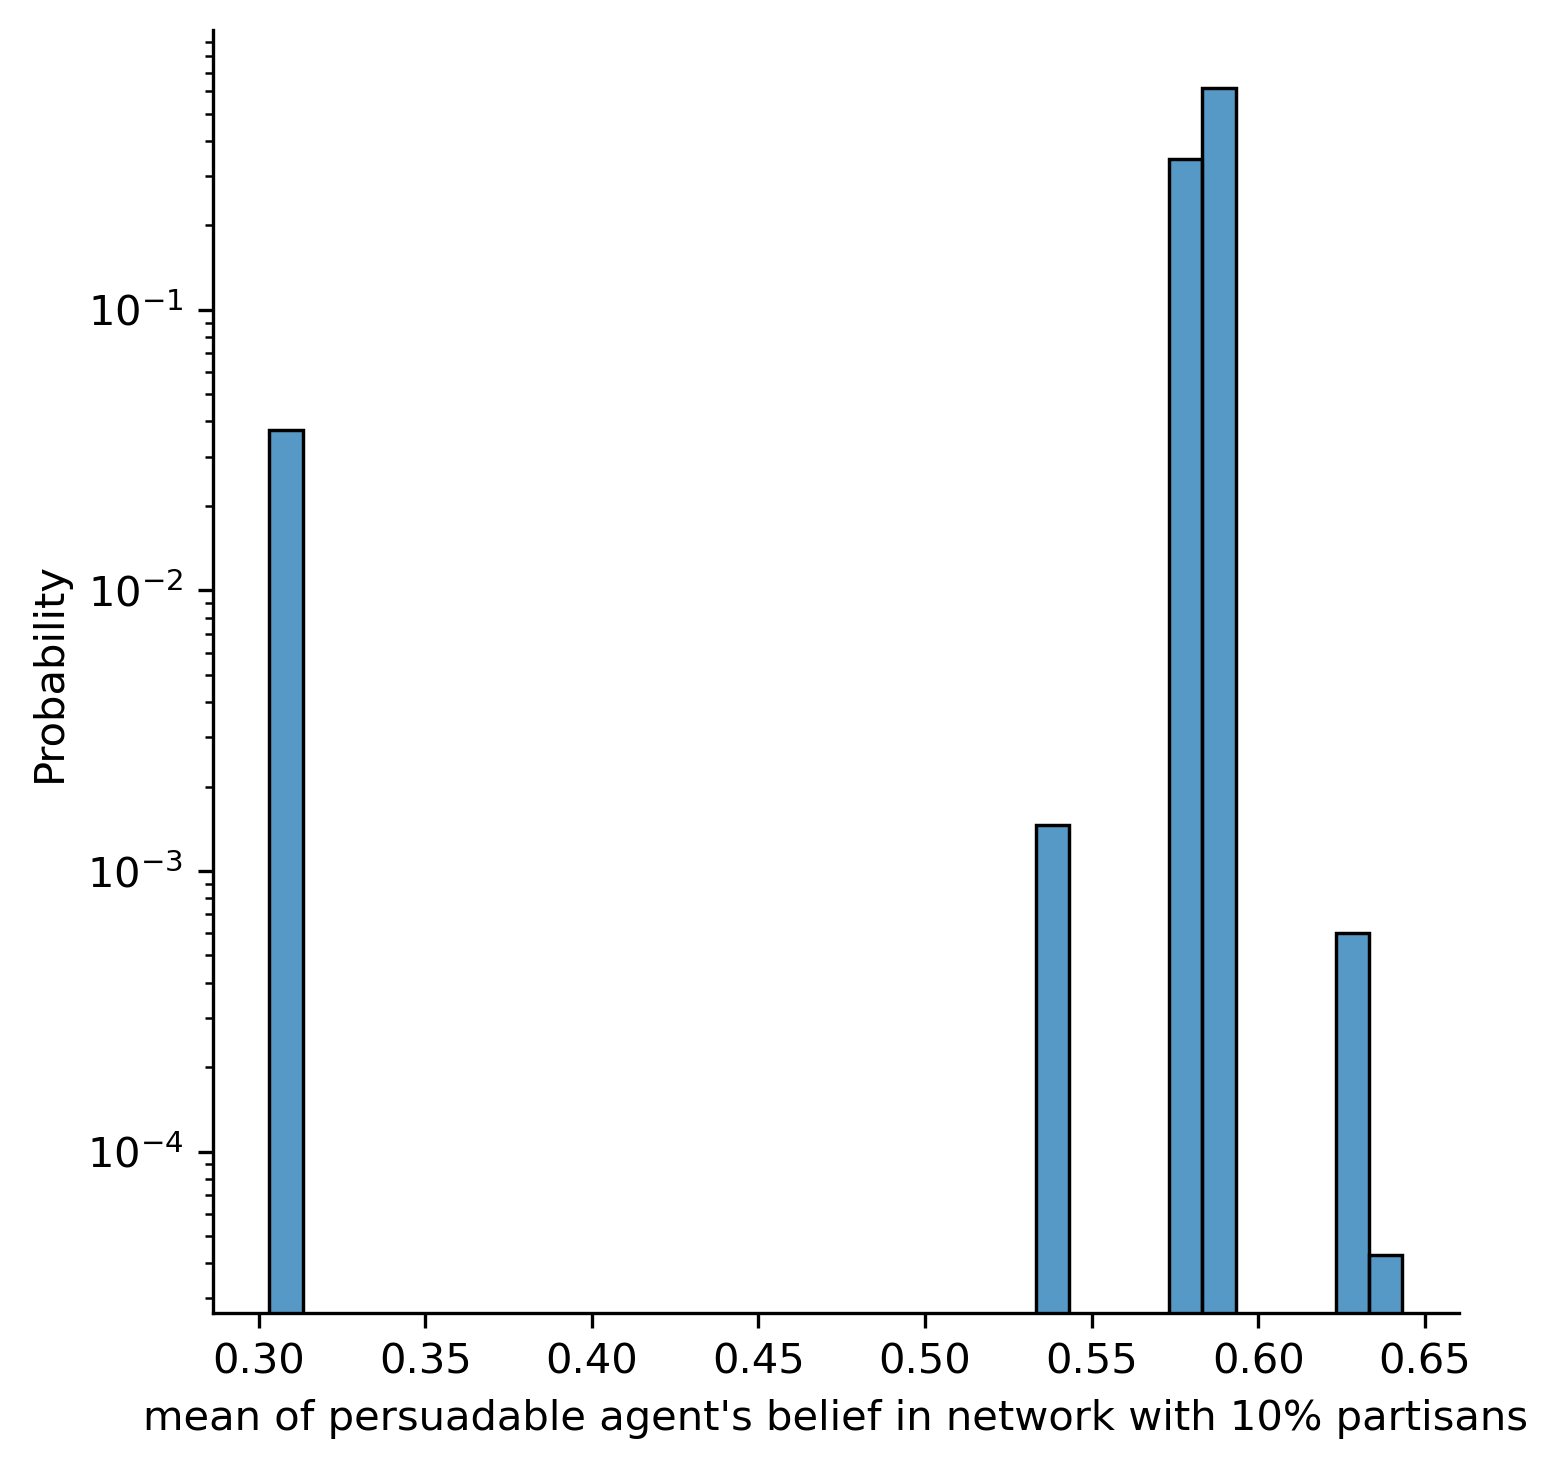

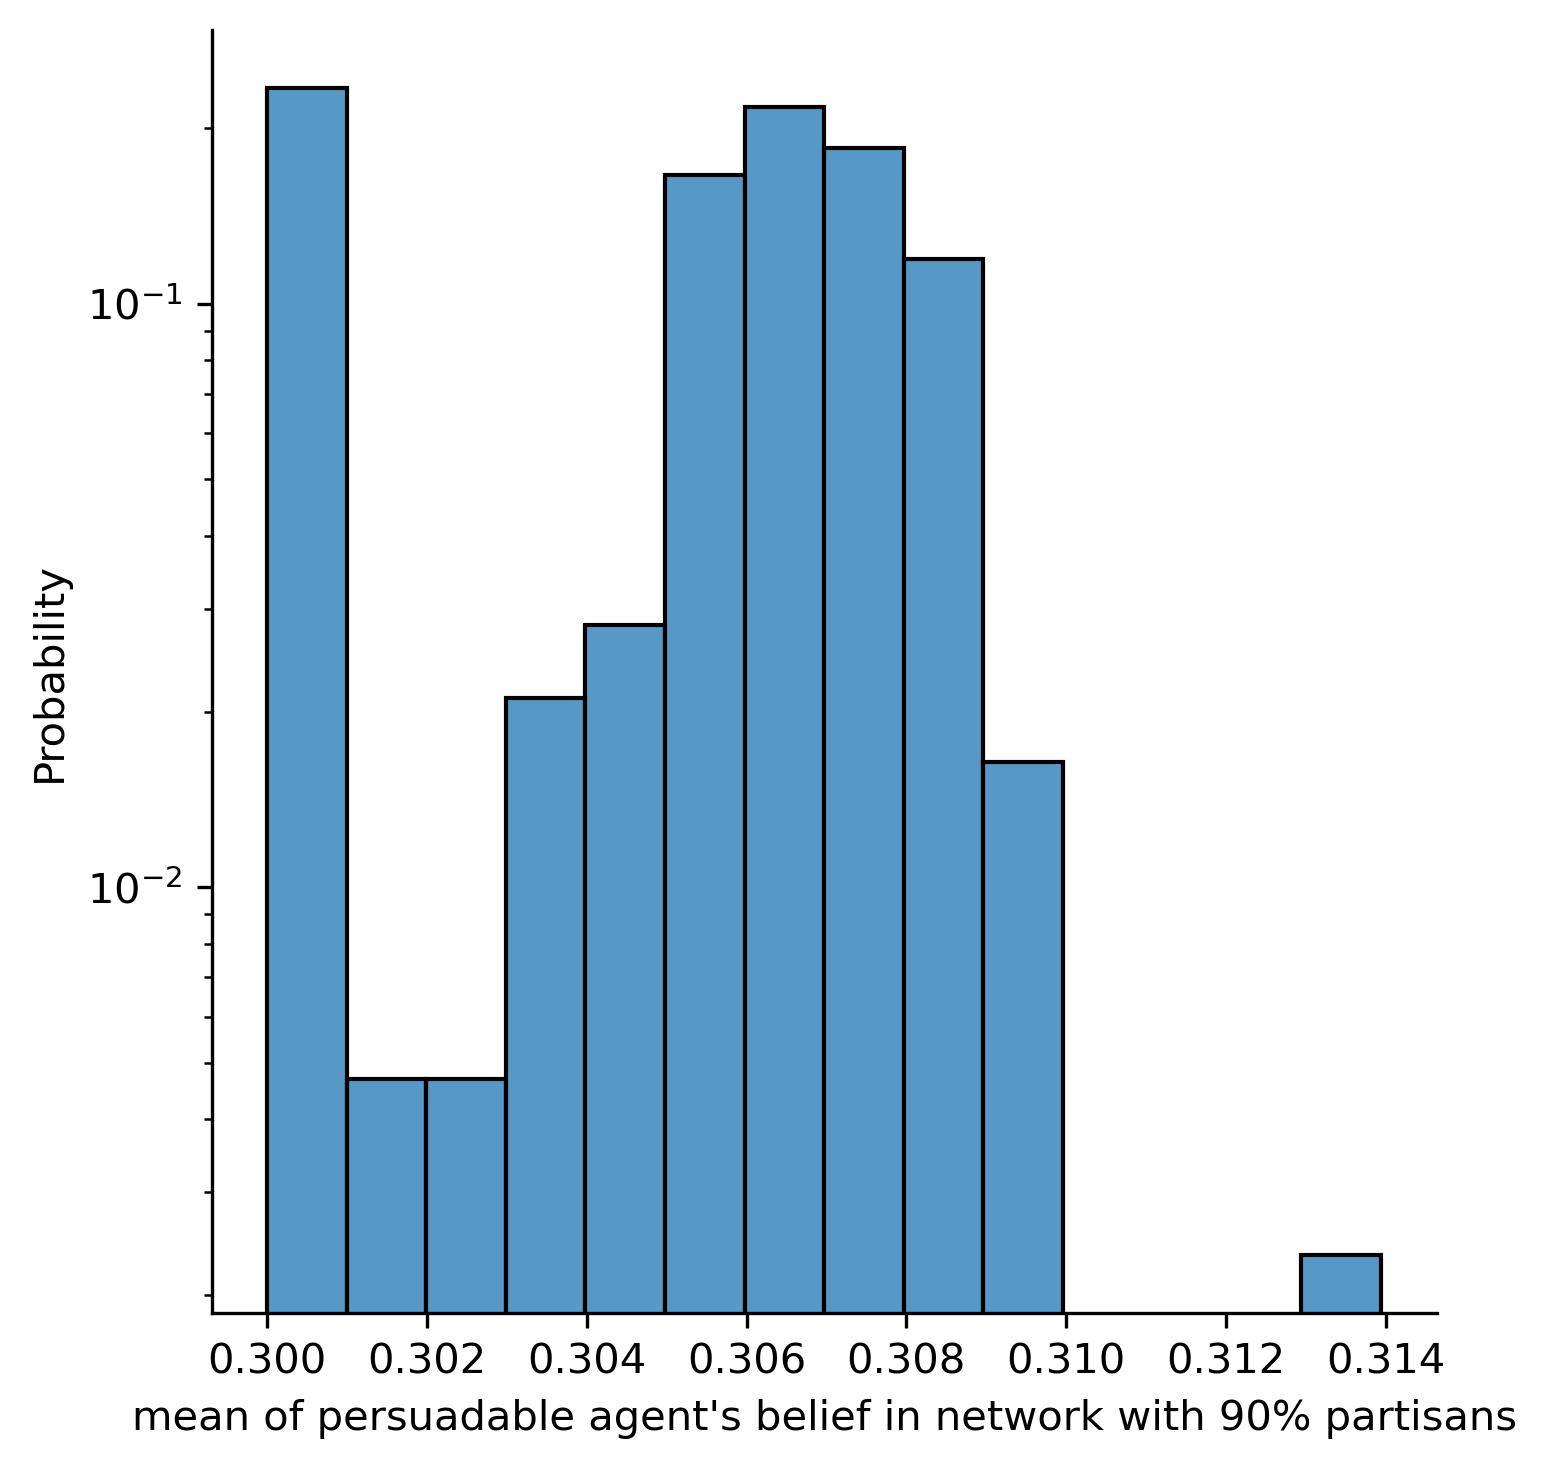

In [286]:
# Dwell interval histogram
sns.displot(df[df.partisans == 0.1],x='non_partisan_mean',stat="probability", binwidth=0.01)
plt.yscale("log")
# plt.xlim(0,1)
plt.xlabel("mean of persuadable agent's belief in network with 10% partisans")
# sns.displot(df[df.partisans == 0.01],x='non_partisan_mean', hue="bias", stat = "probability", binwidth=0.01)
sns.displot(df[df.partisans == 0.91],x='non_partisan_mean', stat="probability")
# sns.displot(df[df.partisans == 0.99],x='non_partisan_mean', hue="bias", stat="probability")
# plt.xlim(0.30,0.7) }
plt.yscale("log")
plt.xlabel("mean of persuadable agent's belief in network with 90% partisans")
#TODO: Peakn at 0.306? 

In [208]:
# dwell_interval = []
# for frac in df.partisans.unique():
#     dwell_interval.append(df[df.partisans ==frac].shape[0])
#     plt.plot(dwell_interval)

# # sns.displot(df[df.partisans == 0.9].shape[0],x='non_partisan_mean', hue="bias", stat="probability", binwidth=0.01)

# # plt.yscale("log")
# # 
